# Exploring Sunshine Data

## Summary
This notebook accompanies a NI4AI [blog post](https://blog.ni4ai.org/post/2020-03-30-sunshine-data/) written by Sascha von Meier. It presents an introductory exploration of the open-access "Sunshine" data hosted by NI4AI.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from library.utils import describe_streams, streams_to_df
import btrdb
from btrdb.utils.general import pointwidth
from btrdb.utils.timez import ns_delta, ns_to_datetime, to_nanoseconds

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
plt.style.use('fivethirtyeight')

## Connect to database 

In [2]:
#Establishing the connecting to the server
db = btrdb.connect(profile='ni4ai')

## Listing out the streams 

Data streams are organized into a hierarchichal tree of _collections_. Let’s see the collections available in the Sunshine dataset using the `list_collections` method.

In [3]:
db.list_collections("sunshine")

['sunshine/PMU1',
 'sunshine/PMU2',
 'sunshine/PMU3',
 'sunshine/PMU4',
 'sunshine/PMU5',
 'sunshine/PMU6']

Let's take a look at the streams in one of these collections; we will pick **sunshine/PMU3** here.

In [4]:
streams = db.streams_in_collection('sunshine/PMU3')
print(describe_streams(streams))

  Index  Collection     Name    Units    UUID
-------  -------------  ------  -------  ------------------------------------
      0  sunshine/PMU3  C3ANG   deg      b3ca2159-8fa7-4341-801d-d1228af675b7
      1  sunshine/PMU3  C2ANG   deg      c71f34d1-3cba-4959-b4b9-032ec078c66d
      2  sunshine/PMU3  C3MAG   amps     cd6d2be2-6b7b-4c46-be1e-8432990ef23c
      3  sunshine/PMU3  L1ANG   deg      bc73226c-c877-438a-ab37-7a6703cbfbce
      4  sunshine/PMU3  C2MAG   amps     47da9f9a-f8d9-4955-9e87-9c17dabde298
      5  sunshine/PMU3  C1ANG   deg      bc9d458c-9b54-4ad2-b837-53170a4d7331
      6  sunshine/PMU3  L2ANG   deg      f4b400e1-26f4-4ca9-b301-c2fbb7d77e87
      7  sunshine/PMU3  L1MAG   volts    0295f80f-6776-4384-b563-4582f7256600
      8  sunshine/PMU3  C1MAG   amps     1e641edc-d95a-494f-99f3-cbb991ef05bf
      9  sunshine/PMU3  L3ANG   deg      fabd1511-f6f8-4670-b336-7fbfe412e4a2
     10  sunshine/PMU3  L2MAG   volts    38d62795-6341-4069-96d3-fe74bffcac67
     11  sunshine/

## Querying data

In [5]:
#Choose a time window
start = to_nanoseconds('2015-08-15 3:42:00')
end = to_nanoseconds('2015-08-15 3:47:00')
s = streams[4]

### Querying raw data 

In [6]:
#Retrieve values from stream 4 (current magnitude for PMU 1)
data = s.values(start, end)
data[:2]

[(RawPoint(1439610120008333000, 255.79547119140625), 123468),
 (RawPoint(1439610120016666000, 255.64520263671875), 123468)]

Values are returned as a list of tuples each of which contains a RawPoint and the associated version. Each RawPoint object includes a time stamp in nanoseconds and a measurement value.

```
(RawPoint(time_stamp, value), version)
```

In [7]:
# Retrieve only the RawPoint objects (without the version)
points, _ = zip(*data)

# Unpack raw points into time stamps and values
times, values = zip(*points)

# Convert time stamps (in nanoseconds) to datetime objects
dtimes = [ns_to_datetime(t) for t in times]

# Convert to a Series, using the time stamp as an index
series = pd.Series(values, index=dtimes)

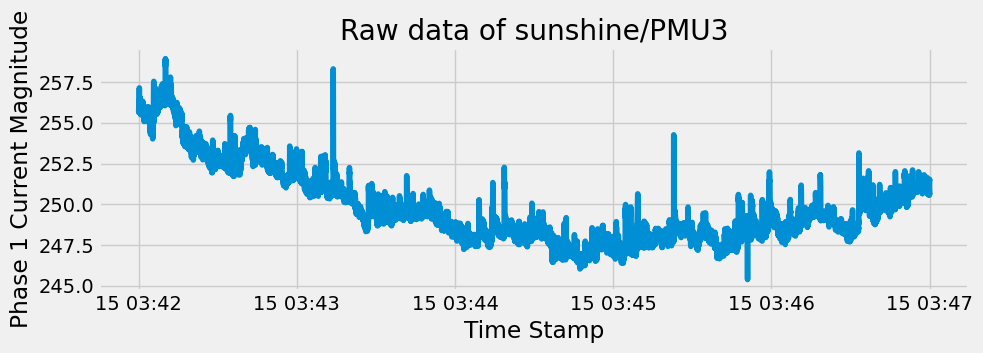

In [8]:
# Graph time series measurements
plt.figure(figsize=(10,3))
plt.plot(series)
plt.xlabel('Time Stamp')
plt.ylabel('Phase 1 Current Magnitude')
plt.title(f'Raw data of {s.collection}')
plt.show()

### Querying data using aligned_windows()

We can also use the `aligned_windows()` function provided by BTrdB python binding to query stream in a fast manner. Each point returned by `aligned_windows()` is a statistical aggregate of all the raw data within a window of width 2**`pointwidth` nanoseconds. These statistical aggregates currently include the mean, minimum, and maximum of the data and the count of data points composing the window.

In [9]:
pw=30
print(f'pw = {pw} is equivalent to {pointwidth(pw).seconds} seconds')
statpoints, _ = zip(*s.aligned_windows(start, end, pw))
statpoints[:2]

pw = 30 is equivalent to 1.073741824 seconds


(StatPoint(1439610119569539072, 255.33578491210938, 256.05949437341025, 257.14947509765625, 129, 0.28065728361818304),
 StatPoint(1439610120643280896, 255.49465942382812, 255.92661480570948, 256.32763671875, 129, 0.186933864367365))

In [10]:
sps_time, sps_min, sps_mean, sps_max, sps_count, sps_stddev = zip(*statpoints)
df = pd.DataFrame(zip(sps_min, sps_mean, sps_max), 
                  columns=['min', 'mean', 'max'],
                  index=sps_time)
df.index = pd.to_datetime(df.index)
df.head()

,min,mean,max
2015-08-15 03:41:59.569539072,255.335785,256.059494,257.149475
2015-08-15 03:42:00.643280896,255.494659,255.926615,256.327637
2015-08-15 03:42:01.717022720,255.081131,255.550027,255.911972
2015-08-15 03:42:02.790764544,255.086945,255.583973,255.975159
2015-08-15 03:42:03.864506368,254.283966,254.963412,255.951706


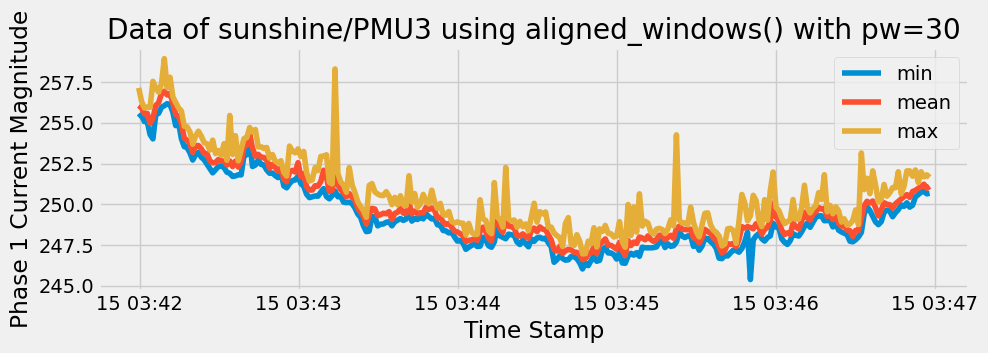

In [11]:
# Graph time series measurements
plt.figure(figsize=(10,3))
plt.plot(df)
plt.legend(['min', 'mean', 'max'])
plt.xlabel('Time Stamp')
plt.ylabel('Phase 1 Current Magnitude')
plt.title(f'Data of {s.collection} using aligned_windows() with pw={pw}')
plt.show()

### Querying data using windows()

Alternatively, you can also use `windows()` to query data at an aggregated windows. Note that `windows()` is slower than `aligned_windows()`, but still significantly faster than RawValues. 

In [12]:
width = ns_delta(seconds=5)
statpoints, _ = zip(*s.windows(start, end, width=width))
statpoints[:2]

(StatPoint(1439610120000000000, 254.28396606445312, 255.57020739237467, 257.14947509765625, 600, 0.4625368124175257),
 StatPoint(1439610125000000000, 254.0181884765625, 256.18148124694824, 257.55133056640625, 600, 0.7214183889759518))

In [13]:
sps_time, sps_min, sps_mean, sps_max, sps_count, sps_stddev = zip(*statpoints)
df = pd.DataFrame(zip(sps_min, sps_mean, sps_max), 
                  columns=['min', 'mean', 'max'],
                  index=sps_time)
df.index = pd.to_datetime(df.index)
df.head()

,min,mean,max
2015-08-15 03:42:00,254.283966,255.570207,257.149475
2015-08-15 03:42:05,254.018188,256.181481,257.551331
2015-08-15 03:42:10,254.832428,256.349866,258.946869
2015-08-15 03:42:15,253.163681,254.320713,255.921280
2015-08-15 03:42:20,252.716782,253.407168,254.488434


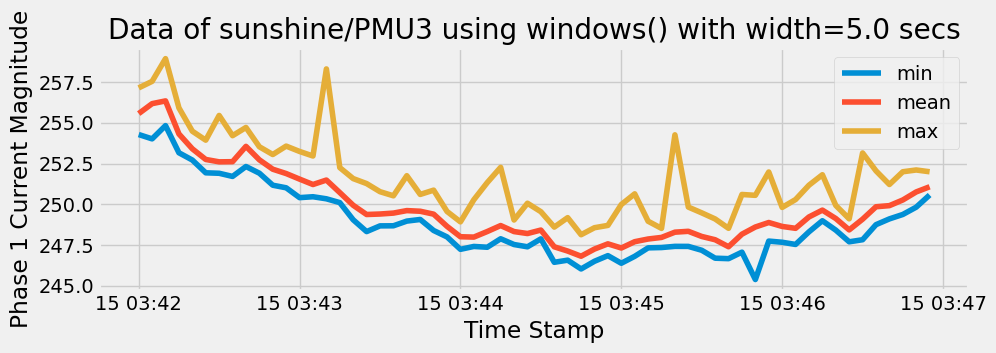

In [14]:
# Graph time series measurements
plt.figure(figsize=(10,3))
plt.plot(df)
plt.legend(['min', 'mean', 'max'])
plt.xlabel('Time Stamp')
plt.ylabel('Phase 1 Current Magnitude')
plt.title(f'Data of {s.collection} using windows() with width={round(width/1e9,2)} secs')
plt.show()

### Helper function

When both `pw` or `width` are not specified, the `.values()` function will be used in `streams_to_df()` to query the data at the raw level.

In [15]:
df = streams_to_df(s, start, end, to_datetime=True)
df.head()

Getting streams:   0%|          | 0/1 [00:00<?, ?it/s]

collection,sunshine/PMU3
unit,amps
name,C2MAG
agg,value
time,
2015-08-15 03:42:00.008333,255.795471
2015-08-15 03:42:00.016666,255.645203
2015-08-15 03:42:00.024999,255.855667
2015-08-15 03:42:00.033333,256.049286
2015-08-15 03:42:00.041666,256.009125


When `pw` is specified, the `.aligned_windows()` function will be used in `streams_to_df()` to query the data at the specified pointwidth.

In [16]:
# return all the statspoints if agg is not specified
df = streams_to_df(s, start, end, pw=30, to_datetime=True)
df.head()

Getting streams:   0%|          | 0/1 [00:00<?, ?it/s]

collection                    sunshine/PMU3                                \
unit                                   amps                                 
name                                  C2MAG                                 
agg                                     min        mean         max count   
time                                                                        
2015-08-15 03:41:59.569539072    255.335785  256.059494  257.149475   129   
2015-08-15 03:42:00.643280896    255.494659  255.926615  256.327637   129   
2015-08-15 03:42:01.717022720    255.081131  255.550027  255.911972   128   
2015-08-15 03:42:02.790764544    255.086945  255.583973  255.975159   129   
2015-08-15 03:42:03.864506368    254.283966  254.963412  255.951706   129   

collection                               
unit                                     
name                                     
agg                              stddev  
time                                     
2015-08-15 03:41:59.569539072  0.280657  
2015-08-15 03:42:00.643280896  0.186934  
2015-08-15 03:42:01.717022720  0.195636  
2015-08-15 03:42:02.790764544  0.193851  
2015-08-15 03:42:03.864506368  0.393079

In [17]:
# return only the specified the statspoints if agg is specified
df = streams_to_df(s, start, end, pw=30, agg=['min', 'mean', 'max'], to_datetime=True)
df.head()

Getting streams:   0%|          | 0/1 [00:00<?, ?it/s]

collection                    sunshine/PMU3                        
unit                                   amps                        
name                                  C2MAG                        
agg                                     min         max        mean
time                                                               
2015-08-15 03:41:59.569539072    255.335785  257.149475  256.059494
2015-08-15 03:42:00.643280896    255.494659  256.327637  255.926615
2015-08-15 03:42:01.717022720    255.081131  255.911972  255.550027
2015-08-15 03:42:02.790764544    255.086945  255.975159  255.583973
2015-08-15 03:42:03.864506368    254.283966  255.951706  254.963412

When `width` is specified, the `.windows()` function will be used in `streams_to_df()` to query the data at the specified `width` (and `depth`).

In [18]:
df = streams_to_df(s, start, end, 
                   width=ns_delta(minutes=1), 
                   agg=['min', 'mean', 'max'], 
                   to_datetime=True)
df.head()

Getting streams:   0%|          | 0/1 [00:00<?, ?it/s]

collection          sunshine/PMU3                        
unit                         amps                        
name                        C2MAG                        
agg                           min         max        mean
time                                                     
2015-08-15 03:42:00    251.011841  258.946869  253.677880
2015-08-15 03:43:00    247.994873  258.314453  250.029909
2015-08-15 03:44:00    246.026428  252.269287  247.841088
2015-08-15 03:45:00    245.376968  254.265610  248.029400
2015-08-15 03:46:00    247.532593  253.152039  249.543494

In [19]:
df = streams_to_df(s, start, end, 
                   width=ns_delta(minutes=1), 
                   depth=ns_delta(seconds=1),
                   agg=['min', 'mean', 'max'], 
                   to_datetime=True)
df.head()

Getting streams:   0%|          | 0/1 [00:00<?, ?it/s]

collection          sunshine/PMU3                        
unit                         amps                        
name                        C2MAG                        
agg                           min         max        mean
time                                                     
2015-08-15 03:42:00    251.011841  258.946869  253.677880
2015-08-15 03:43:00    247.994873  258.314453  250.029909
2015-08-15 03:44:00    246.026428  252.269287  247.841088
2015-08-15 03:45:00    245.376968  254.265610  248.029400
2015-08-15 03:46:00    247.532593  253.152039  249.543494